# Testing regularization of likelihood functions

In [3]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


Populating the interactive namespace from numpy and matplotlib


In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Creating the forward model

In [240]:
ndim = 2
means = np.array([0., 1.]).astype('float32')
stddevs = np.array([1., 2.]).astype('float32')


tf.reset_default_graph()
batch_size=10000
# This is the linear operator
A = tf.constant(randn(2,2), dtype=tf.float32) / 2.

# Defining probabilistic forward model
prior = tfd.Normal(loc=means, scale=stddevs)

# Defining the forward model
x = prior.sample(batch_size)
l = tf.reduce_sum(tf.matmul(x, A), axis=1)
p = tfd.Poisson(log_rate=l)
y = tf.reshape(p.sample(), (-1,))


In [241]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sx, sy, sl, AA = sess.run([x, y, l, A])

/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


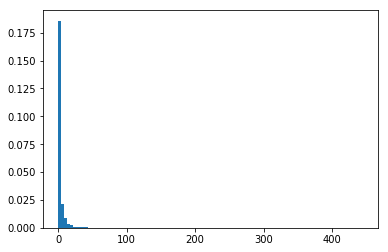

In [243]:
plt.hist(sy, bins=100, normed=True)
plt.show()

In [244]:
sl.max(), sy.max()

(6.1387625, 444.0)

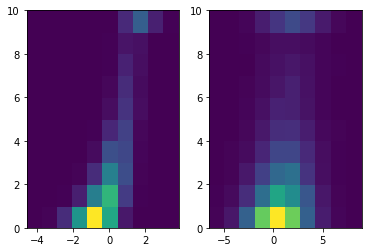

In [245]:
subplot(121)
# hist2d(sx[:,0], sy);
hist2d(sx[:,0], clip(sy.flatten(),0,10));
subplot(122)
# hist2d(sx[:,1], sy);
hist2d(sx[:,1], clip(sy.flatten(),0,10));

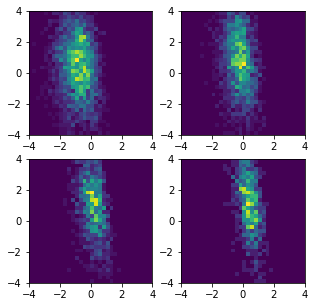

In [246]:
# Have a look at the posterior on x for a given outcome y
figure(figsize=(5,5))
for i in range(4):
    subplot(2,2,i+1)
    m = (sy == i)
    hist2d(sx[:,0][m], sx[:,1][m],32,range=[[-4,4],[-4,4]],normed=True);gca().set_aspect('equal');

In [247]:
# Now, let's try to train a neural network to model the likelihood function

# Module

Train a neural network in a module 

In [248]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [249]:
tf.reset_default_graph()


def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')

    net = tf.layers.dense(x,32)
    net = tf.layers.dense(net,16)
    net = tf.layers.dense(net,1)
#     net = tf.nn.softplus(net, name='lograte')
    out_prob = tfd.Poisson(log_rate=net, name='out_prob')
    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
#     hub.add_signature(inputs=inputs, outputs=outputs)

    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
lograte = module({'features':xx, 'labels':sy}, as_dict=True)['lograte']
loglik = module({'features':xx, 'labels':sy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':sy}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

lrate0 = sess.run(lograte, feed_dict={xx:sx[:10]})
for i in range(2000):
    l,_= sess.run([loss, train_op], feed_dict={xx:sx})
    losses.append(l)
lrate1 = sess.run(lograte, feed_dict={xx:sx[:10]})
pred = sess.run(sample, feed_dict={xx:sx})


# module.export('./densemodule', sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


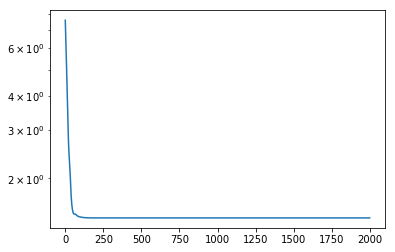

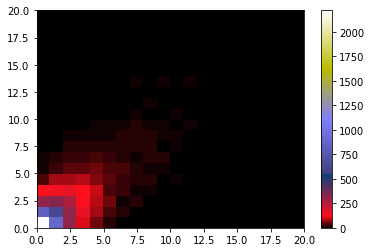

In [250]:
plot(losses)
plt.yscale('log')
plt.show()
hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
plt.colorbar()
plt.show()

In [251]:
# %%bash
# ls
# rm -r densemodule


densemodule
Inverse_stability.ipynb
MAF.ipynb
README.md


In [253]:
# module.export('./densemodule', sess)


INFO:tensorflow:Exported TF-Hub module to: ./densemodule


Ok, fair enough

In [200]:
# Now, let's see what happens if we try to maximize p(y | x) with respect to x 


Ok, so there is a little bit of code restructuring to do, but the idea here is to see if when we do gradient descent over x, we end up far away from a credible input x value, by that I mean, is $\hat{x}$ within the posterior on x for y=4

# Reconstruct here

In [274]:

def dorecon(yy):
    tf.reset_default_graph()
    module = hub.Module('./densemodule/')

    xrecon = tf.get_variable('xrecon', shape=(yy.shape[0], 2), 
                             initializer=tf.random_normal_initializer(mean=(0, 0)), trainable=True)

    loglik = -module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
    print(loglik.shape)
    prior = tf.square(xrecon)
    prior = tf.multiply(prior, stddevs**-2)
    prior = tf.reduce_sum(prior, axis=-1, keepdims=True)
    print(prior.shape)
    loss = tf.add(loglik, prior)
#     loss = loglik
    print(loss.shape)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])

    niter = 5000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        for it in range(niter+1):
            _, l = sess.run([opt_op, loss])
            losses.append(l)
        xfin = sess.run(xrecon)
        
    return xfin, losses

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(512, 1)
(512, 1)
(512, 1)
0 3609
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(512, 1)
(512, 1)
(512, 1)
2 1256
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(512, 1)
(512, 1)
(512, 1)
4 505


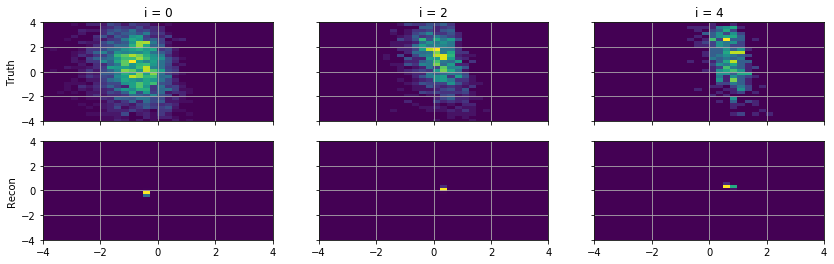

In [275]:
tf.reset_default_graph()

fig, ax = plt.subplots(2,3, figsize=(14, 4), sharex=True, sharey=True)
xfins = []
for i in range(3):
    ii = 2*i
    yy = ii* ones((512)).astype('float32')
    recons = dorecon(yy)
    xfin = np.squeeze(recons[0])
    xfins.append(xfin)
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],32,range=[[-4,4],[-4,4]],normed=True)#;gca().set_aspect('equal')
    ax[1, i].hist2d(xfin.T[0].flatten(), xfin.T[1].flatten(),32,
           range=[[-4,4],[-4,4]],normed=True)#;gca().set_aspect('equal')
    ax[0, i].set_title('i = %d'%ii)
    ax[0, 0].set_ylabel('Truth')
    ax[1, 0].set_ylabel('Recon')
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


# recons = []
# for i in range(10):
#     recons.append(dorecon(np.array(ii).reshape(-1)))

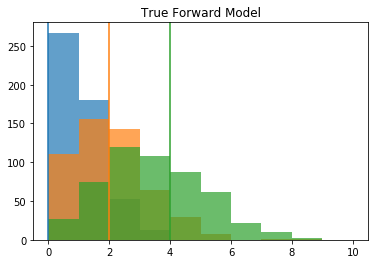

In [276]:
for i in range(3):
    rates = np.array([np.matmul(i, AA) for i in xfins[i]]).sum(axis=1)
    plt.hist(np.random.poisson(np.exp(rates)), alpha=0.7, range=(0, 10), bins=10, color='C%d'%i)
    plt.axvline(2*i, color='C%d'%i)
    plt.title('True Forward Model')

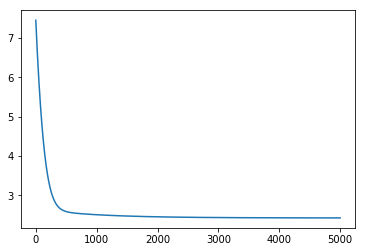

In [277]:
plt.plot(np.squeeze(np.array(recons[1])[:, 0]))
# plt.plot(np.array(recons[0][1]).flatten())

In [126]:
# xfin = np.array([i[0] for i in recons])
xfin = np.squeeze(recons[0])
xfin

array([[-0.25911194,  0.07700069],
       [-0.34185737,  0.10125051],
       [-1.2307714 ,  0.37744033],
       ...,
       [ 0.9635273 , -0.30178088],
       [-0.22825548,  0.0673166 ],
       [-1.2334999 ,  0.37837496]], dtype=float32)

1 42


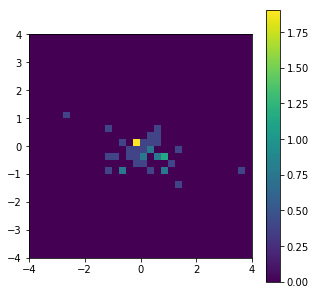

In [127]:
# Have a look at the posterior on x for a given outcome y
figure(figsize=(5,5))
m = (sy == ii)
print(ii, m.sum())
hist2d(sx[:,0][m], sx[:,1][m],32,range=[[-4,4],[-4,4]],normed=True);gca().set_aspect('equal');
plt.colorbar()


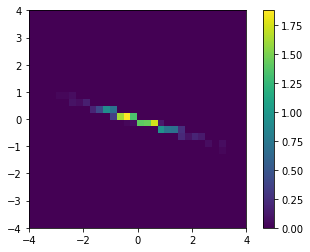

In [130]:
hist2d(xfin.T[0].flatten(), xfin.T[1].flatten(),32,
           range=[[-4,4],[-4,4]],normed=True);gca().set_aspect('equal');
plt.colorbar()


(array([  7.,  11.,  46., 116., 115., 117.,  64.,  21.,  12.,   3.]),
 array([-2.7806737 , -2.177853  , -1.5750324 , -0.9722117 , -0.36939102,
         0.23342967,  0.83625036,  1.439071  ,  2.0418918 ,  2.6447124 ,
         3.247533  ], dtype=float32),
 <a list of 10 Patch objects>)

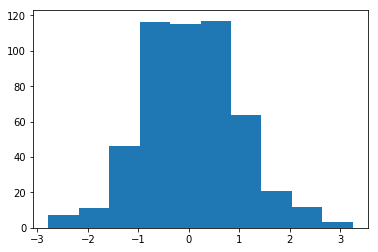

In [131]:
plt.hist(xfin[:, 0])

In [12]:
# # net = tf.layers.dense(x,32)
# # net = tf.layers.dense(net,1)
# net = tf.layers.dense(x,32)
# net = tf.layers.dense(net,16)
# net = tf.layers.dense(net,1)
# out_prob = tfd.Poisson(log_rate=net)
# pred = out_prob.sample()

# loss = -tf.reduce_mean(out_prob.log_prob(tf.expand_dims(y, axis=-1)))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
# train_op = optimizer.minimize(loss)

# sess.run(tf.global_variables_initializer())

# losses =[]
# for i in range(1000):
#     l,_= sess.run([loss, train_op])
#     losses.append(l)
    
# plot(losses)
# plt.yscale('log')


# # Try to predict the outcome
# tp, ty = sess.run([pred,y])

# hist2d(tp[:,0],ty,20,range=[[0,20],[0,20]],cmap='gist_stern');
# plt.colorbar()
